Encontrando uma relação linear entre as colunas para que seja possivel identificar qual modelo melhor se encaixa : random forest ou linear regression.

In [1078]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1079]:
db_alugueis = pd.read_csv('historico_alugueis.csv')

### Limpando os dados 

In [1080]:
#retirnando linhas que contem todos os valores nulos e linhas duplicadas
db_alugueis.dropna(how='all', inplace=True)
db_alugueis = db_alugueis.drop_duplicates()

# Apagando colunas que não serão utilizadas


In [1081]:
# Passando por cada coluna para tratar ela da melhor forma
# Utilizando primeiro o display com unique para entender os valores unicos de cada coluna
# Em seguida realizando o tratamento de acordo com o que foi observado
db_alugueis = db_alugueis.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
db_alugueis = db_alugueis.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)

# Tratando a coluna 'ID do aluguel'
db_alugueis['ID do cliente'] = db_alugueis['ID do cliente'].astype(int)

# Tratando a coluna 'tipo de carro alugado'

# Tratando a coluna 'Tempo de aluguel'
db_alugueis['Tempo de aluguel'] = db_alugueis['Tempo de aluguel'].astype(int)

#Data de inicio
import re

# Function to convert months in Portuguese-English mix to standard format
# Modify the function to handle non-string (NaN) values safely

def convert_portuguese_date_format(date_str):
    if isinstance(date_str, str):
        # Mapping English month names to their corresponding numbers
        months_mapping = {
            'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
            'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
            'november': '11', 'december': '12'
        }

        # Pattern to match the format '6 de january de 2022'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                return f'{day}/{month_num}/{year}'
    return date_str  # Return as is if it's not a match or not a string

db_alugueis['Data de início do aluguel'] = db_alugueis['Data de início do aluguel'].apply(convert_portuguese_date_format)
db_alugueis['Data de início do aluguel'] = pd.to_datetime(db_alugueis['Data de início do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Data final do aluguel'    
db_alugueis['Data final do aluguel'] = db_alugueis['Data final do aluguel'].apply(convert_portuguese_date_format)
db_alugueis['Data final do aluguel'] = pd.to_datetime(db_alugueis['Data final do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Valor do contrato do aluguel'
def clean_valor_do_contrato(value):
    if isinstance(value, str):
        value = value.lower()
        value = value.replace('r$', '').replace('.', '').replace(',', '.').strip()
    return float(value) if value else None

db_alugueis['Valor do contrato do aluguel'] = db_alugueis['Valor do contrato do aluguel'].apply(clean_valor_do_contrato)

#Tratando a coluna Idade do carro
db_alugueis['Idade do carro'] = db_alugueis['Idade do carro'].astype(int)

# Tratando a coluna Satisfação do cliente
db_alugueis['Satisfação do cliente'] = db_alugueis['Satisfação do cliente'].astype(int)

# Tratando Desconto aplicado no contrato
db_alugueis['Desconto aplicado no contrato'] = db_alugueis['Desconto aplicado no contrato'].apply(clean_valor_do_contrato)

# Criando coluna valor médio do carro por mês
db_alugueis['Valor médio do carro por mês'] = db_alugueis['Valor do contrato do aluguel'] / db_alugueis['Tempo de aluguel']
                              


C:\Users\Patricia\AppData\Local\Temp\ipykernel_10208\2629263365.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  db_alugueis = db_alugueis.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
C:\Users\Patricia\AppData\Local\Temp\ipykernel_10208\2629263365.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  db_alugueis = db_alugueis.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)


In [1082]:
categorical_columns = db_alugueis.select_dtypes(include=['object', 'category']).columns
categorical_columns

Index(['Tipo do cliente', 'Tipo de carro alugado', 'Estado de pagamento',
       'Método de pagamento', 'Qualidade do carro', 'Tipo de transmissão',
       'Combustível', 'Marca do carro', 'Cor do carro',
       'Tipo do problema para contactar o suporte',
       'Contrato cancelado antes do prazo', 'Motivo do cancelamento',
       'Histórico de contratos anteriores', 'Pagamentos atrasados'],
      dtype='object')

In [1083]:
db_alugueis

,ID do cliente,Tipo do cliente,Tipo de carro alugado,Tempo de aluguel,Data de início do aluguel,Data final do aluguel,Valor do contrato do aluguel,Estado de pagamento,Método de pagamento,Quilometragem do carro,...,Cor do carro,Interações com o suporte,Tipo do problema para contactar o suporte,Satisfação do cliente,Contrato cancelado antes do prazo,Motivo do cancelamento,Desconto aplicado no contrato,Histórico de contratos anteriores,Pagamentos atrasados,Valor médio do carro por mês
0,56367,b2b,sedan,18,2022-01-06,2023-06-30,86040.0,pendente,boleto,64503.0,...,cinza,0.0,NaN,5,não,NaN,14.0,não,sim,4780.0
1,57635,b2c,caminhonete,1,2023-04-22,2023-05-22,8040.0,quitado,boleto,32642.0,...,cinza,0.0,NaN,5,sim,troca de veículo,10.0,não,não,8040.0
2,10730,b2b,sedan,24,2022-06-20,2024-06-09,58272.0,quitado,cartão de crédito,146833.0,...,prata,0.0,NaN,4,não,NaN,13.0,não,sim,2428.0
3,60276,b2c,caminhonete,1,2024-06-28,2024-07-28,6957.0,quitado,cartão de crédito,20257.0,...,prata,2.0,pneu furado,5,não,NaN,2.0,não,não,6957.0
4,58409,b2c,sedan,1,2023-11-07,2023-12-07,4045.0,quitado,boleto,140589.0,...,cinza,1.0,acidente,5,não,NaN,15.0,sim,não,4045.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104659,24396,b2c,suv,1,2023-01-25,2023-02-24,8553.0,quitado,boleto,35884.0,...,cinza,1.0,acidente,1,não,NaN,10.0,não,não,8553.0
104660,34626,b2c,suv,3,2024-08-09,2024-11-07,17370.0,pendente,boleto,100560.0,...,prata,0.0,NaN,5,não,NaN,2.0,não,não,5790.0
104661,41711,b2c,suv,3,2023-07-17,2023-10-15,15483.0,quitado,cartão de crédito,32388.0,...,branco,0.0,NaN,3,não,NaN,17.0,não,não,5161.0
104662,76612,b2c,suv,1,2023-12-01,2023-12-31,9489.0,quitado,boleto,33057.0,...,prata,2.0,bateria descarregada,4,não,NaN,3.0,não,sim,9489.0


In [1084]:
db_alugueis = db_alugueis.fillna('inexistente')

In [1085]:
db_alugueis

,ID do cliente,Tipo do cliente,Tipo de carro alugado,Tempo de aluguel,Data de início do aluguel,Data final do aluguel,Valor do contrato do aluguel,Estado de pagamento,Método de pagamento,Quilometragem do carro,...,Cor do carro,Interações com o suporte,Tipo do problema para contactar o suporte,Satisfação do cliente,Contrato cancelado antes do prazo,Motivo do cancelamento,Desconto aplicado no contrato,Histórico de contratos anteriores,Pagamentos atrasados,Valor médio do carro por mês
0,56367,b2b,sedan,18,2022-01-06,2023-06-30,86040.0,pendente,boleto,64503.0,...,cinza,0.0,inexistente,5,não,inexistente,14.0,não,sim,4780.0
1,57635,b2c,caminhonete,1,2023-04-22,2023-05-22,8040.0,quitado,boleto,32642.0,...,cinza,0.0,inexistente,5,sim,troca de veículo,10.0,não,não,8040.0
2,10730,b2b,sedan,24,2022-06-20,2024-06-09,58272.0,quitado,cartão de crédito,146833.0,...,prata,0.0,inexistente,4,não,inexistente,13.0,não,sim,2428.0
3,60276,b2c,caminhonete,1,2024-06-28,2024-07-28,6957.0,quitado,cartão de crédito,20257.0,...,prata,2.0,pneu furado,5,não,inexistente,2.0,não,não,6957.0
4,58409,b2c,sedan,1,2023-11-07,2023-12-07,4045.0,quitado,boleto,140589.0,...,cinza,1.0,acidente,5,não,inexistente,15.0,sim,não,4045.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104659,24396,b2c,suv,1,2023-01-25,2023-02-24,8553.0,quitado,boleto,35884.0,...,cinza,1.0,acidente,1,não,inexistente,10.0,não,não,8553.0
104660,34626,b2c,suv,3,2024-08-09,2024-11-07,17370.0,pendente,boleto,100560.0,...,prata,0.0,inexistente,5,não,inexistente,2.0,não,não,5790.0
104661,41711,b2c,suv,3,2023-07-17,2023-10-15,15483.0,quitado,cartão de crédito,32388.0,...,branco,0.0,inexistente,3,não,inexistente,17.0,não,não,5161.0
104662,76612,b2c,suv,1,2023-12-01,2023-12-31,9489.0,quitado,boleto,33057.0,...,prata,2.0,bateria descarregada,4,não,inexistente,3.0,não,sim,9489.0


In [1086]:
# One-hot encode all categorical features in the dataset
#db_alugueis = pd.get_dummies(db_alugueis, columns=categorical_columns, drop_first=True)
#deleta a primeira coluna apos a divisao entre true e false


In [1087]:
db_alugueis

,ID do cliente,Tipo do cliente,Tipo de carro alugado,Tempo de aluguel,Data de início do aluguel,Data final do aluguel,Valor do contrato do aluguel,Estado de pagamento,Método de pagamento,Quilometragem do carro,...,Cor do carro,Interações com o suporte,Tipo do problema para contactar o suporte,Satisfação do cliente,Contrato cancelado antes do prazo,Motivo do cancelamento,Desconto aplicado no contrato,Histórico de contratos anteriores,Pagamentos atrasados,Valor médio do carro por mês
0,56367,b2b,sedan,18,2022-01-06,2023-06-30,86040.0,pendente,boleto,64503.0,...,cinza,0.0,inexistente,5,não,inexistente,14.0,não,sim,4780.0
1,57635,b2c,caminhonete,1,2023-04-22,2023-05-22,8040.0,quitado,boleto,32642.0,...,cinza,0.0,inexistente,5,sim,troca de veículo,10.0,não,não,8040.0
2,10730,b2b,sedan,24,2022-06-20,2024-06-09,58272.0,quitado,cartão de crédito,146833.0,...,prata,0.0,inexistente,4,não,inexistente,13.0,não,sim,2428.0
3,60276,b2c,caminhonete,1,2024-06-28,2024-07-28,6957.0,quitado,cartão de crédito,20257.0,...,prata,2.0,pneu furado,5,não,inexistente,2.0,não,não,6957.0
4,58409,b2c,sedan,1,2023-11-07,2023-12-07,4045.0,quitado,boleto,140589.0,...,cinza,1.0,acidente,5,não,inexistente,15.0,sim,não,4045.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104659,24396,b2c,suv,1,2023-01-25,2023-02-24,8553.0,quitado,boleto,35884.0,...,cinza,1.0,acidente,1,não,inexistente,10.0,não,não,8553.0
104660,34626,b2c,suv,3,2024-08-09,2024-11-07,17370.0,pendente,boleto,100560.0,...,prata,0.0,inexistente,5,não,inexistente,2.0,não,não,5790.0
104661,41711,b2c,suv,3,2023-07-17,2023-10-15,15483.0,quitado,cartão de crédito,32388.0,...,branco,0.0,inexistente,3,não,inexistente,17.0,não,não,5161.0
104662,76612,b2c,suv,1,2023-12-01,2023-12-31,9489.0,quitado,boleto,33057.0,...,prata,2.0,bateria descarregada,4,não,inexistente,3.0,não,sim,9489.0


ANALISANDO AS FEATURES

Definir quais as features de maior delevancia e talvez fazer alteracoes nas informacoes para uma melhor classificacao do modelo talvez seja a melhor coisa a ser feita antes do processamento em si. Assim:

* Target: 'Contrato cancelado antes do prazo'

* Features: 'Tipo do cliente','Tipo de carro alugado','Tempo de aluguel','Valor do contrato do aluguel', 'Idade do carro', 'Interações com o suporte','Tipo do problema para contactar o suporte','Satisfação do cliente', 'Histórico de contratos anteriores','Pagamentos atrasados'

In [1088]:
db_alugueis.columns

Index(['ID do cliente', 'Tipo do cliente', 'Tipo de carro alugado',
       'Tempo de aluguel', 'Data de início do aluguel',
       'Data final do aluguel', 'Valor do contrato do aluguel',
       'Estado de pagamento', 'Método de pagamento', 'Quilometragem do carro',
       'Qualidade do carro', 'Tipo de transmissão', 'Combustível',
       'Idade do carro', 'Marca do carro', 'Cor do carro',
       'Interações com o suporte', 'Tipo do problema para contactar o suporte',
       'Satisfação do cliente', 'Contrato cancelado antes do prazo',
       'Motivo do cancelamento', 'Desconto aplicado no contrato',
       'Histórico de contratos anteriores', 'Pagamentos atrasados',
       'Valor médio do carro por mês'],
      dtype='object')

In [1089]:
features = ['Tipo do cliente','Tipo de carro alugado','Tempo de aluguel','Valor do contrato do aluguel', 'Idade do carro', 'Interações com o suporte','Tipo do problema para contactar o suporte','Satisfação do cliente', 'Histórico de contratos anteriores','Pagamentos atrasados']

for feature in features:
    display(db_alugueis[feature].value_counts(normalize = True))


Tipo do cliente
b2c    0.699208
b2b    0.300792
Name: proportion, dtype: float64

Tipo de carro alugado
suv            0.400673
sedan          0.299606
caminhonete    0.199658
outro          0.100063
Name: proportion, dtype: float64

Tempo de aluguel
1     0.350369
3     0.209891
12    0.150300
6     0.138948
18    0.090414
24    0.060078
Name: proportion, dtype: float64

Valor do contrato do aluguel
9555.0      0.000172
6426.0      0.000163
6621.0      0.000153
9975.0      0.000153
9987.0      0.000143
              ...   
5781.0      0.000010
69684.0     0.000010
206784.0    0.000010
171918.0    0.000010
225552.0    0.000010
Name: proportion, Length: 29333, dtype: float64

Idade do carro
3    0.198367
2    0.150233
4    0.149975
1    0.149937
5    0.149899
7    0.101421
6    0.100168
Name: proportion, dtype: float64

Interações com o suporte
0.0    0.696989
1.0    0.152548
2.0    0.100168
3.0    0.050295
Name: proportion, dtype: float64

Tipo do problema para contactar o suporte
inexistente              0.696989
manutenção preventiva    0.051251
problema no motor        0.051031
acidente                 0.050887
bateria descarregada     0.050151
pneu furado              0.049874
elétrica                 0.049816
Name: proportion, dtype: float64

Satisfação do cliente
5    0.500316
3    0.200815
4    0.199868
2    0.050419
1    0.048583
Name: proportion, dtype: float64

Histórico de contratos anteriores
não    0.801107
sim    0.198893
Name: proportion, dtype: float64

Pagamentos atrasados
não    0.850274
sim    0.149726
Name: proportion, dtype: float64

In [1090]:
analise_satisfacao = db_alugueis.loc[db_alugueis['Satisfação do cliente']<5,'Contrato cancelado antes do prazo']
print(analise_satisfacao.value_counts(True)*100)

Contrato cancelado antes do prazo
não    90.070623
sim     9.929377
Name: proportion, dtype: float64


Analisando cancelamentos por tempo de aluguel

In [1091]:
analise_tempo = db_alugueis.loc[db_alugueis['Tempo de aluguel']<2,'Contrato cancelado antes do prazo']
print(analise_tempo.value_counts(True)*100)

Contrato cancelado antes do prazo
não    90.140845
sim     9.859155
Name: proportion, dtype: float64


In [1092]:
analise_tempo = db_alugueis.loc[db_alugueis['Tempo de aluguel']>5,'Contrato cancelado antes do prazo']
print(analise_tempo.value_counts(True)*100)

Contrato cancelado antes do prazo
não    89.993693
sim    10.006307
Name: proportion, dtype: float64


In [1093]:
analise_tempo = db_alugueis.loc[db_alugueis['Tempo de aluguel']>15,'Contrato cancelado antes do prazo']
print(analise_tempo.value_counts(True)*100)

Contrato cancelado antes do prazo
não    90.188104
sim     9.811896
Name: proportion, dtype: float64


In [1094]:
print(db_alugueis['Contrato cancelado antes do prazo'].unique())

['não' 'sim']


In [1095]:
for tipo in db_alugueis['Tipo de carro alugado'].unique():
    analise_tipoCarro = db_alugueis.loc[db_alugueis['Tipo de carro alugado']==tipo,'Contrato cancelado antes do prazo'].value_counts(True)
    display(analise_tipoCarro)

Contrato cancelado antes do prazo
não    0.902707
sim    0.097293
Name: proportion, dtype: float64

Contrato cancelado antes do prazo
não    0.901902
sim    0.098098
Name: proportion, dtype: float64

Contrato cancelado antes do prazo
não    0.900396
sim    0.099604
Name: proportion, dtype: float64

Contrato cancelado antes do prazo
não    0.899073
sim    0.100927
Name: proportion, dtype: float64

In [1096]:
db_alugueis['Contrato cancelado antes do prazo'] = db_alugueis['Contrato cancelado antes do prazo'].str.lower().map({
    'sim': 1,    # Canceled
    'não': 0     # Not canceled
})


In [1097]:
print(db_alugueis['Contrato cancelado antes do prazo'].unique())

# Convert to lowercase first, then map to binary

# Group by 'Tipo de carro alugado' and calculate the mean cancellation rate
analise_tipoCarro = db_alugueis.groupby('Tipo de carro alugado')['Contrato cancelado antes do prazo'].mean()

# Print the results
print(analise_tipoCarro)





[0 1]
Tipo de carro alugado
caminhonete    0.098098
outro          0.100927
sedan          0.097293
suv            0.099604
Name: Contrato cancelado antes do prazo, dtype: float64


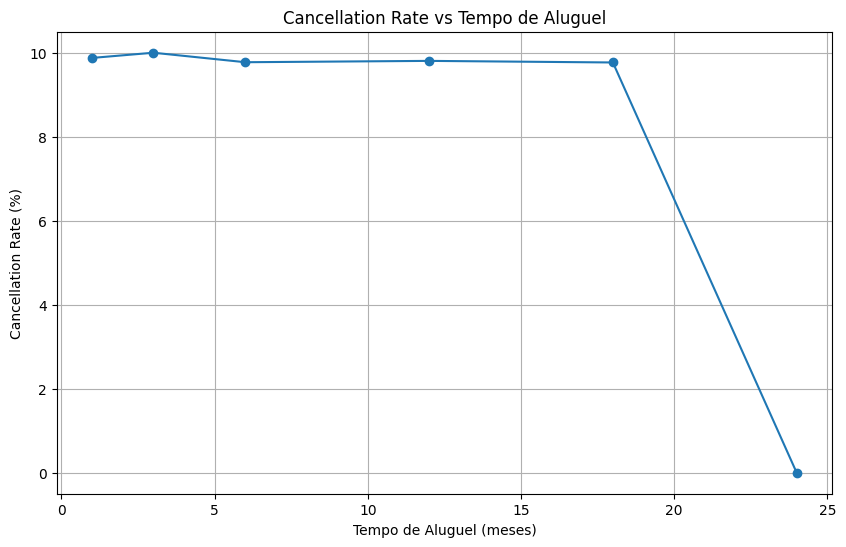

In [1098]:
import matplotlib.pyplot as plt
import pandas as pd

# Check the unique values of 'Tempo de aluguel'
unique_tempo = db_alugueis['Tempo de aluguel'].unique()
unique_tempo_sorted = sorted(unique_tempo)

# Create an empty list to store results for each condition
results = []

# Loop over different 'Tempo de aluguel' values and calculate the cancellation rate
for tempo in unique_tempo_sorted:
    analise_tempo = db_alugueis.loc[db_alugueis['Tempo de aluguel'] > tempo, 'Contrato cancelado antes do prazo']
    cancellation_rate = (analise_tempo.value_counts(normalize=True) * 100).get(1, 0)  # Get cancellation rate, default 0 if no cancellations
    results.append((tempo, cancellation_rate))

# Convert results to a dataframe for easier plotting
results_df = pd.DataFrame(results, columns=['Tempo de aluguel', 'Cancellation Rate'])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Tempo de aluguel'], results_df['Cancellation Rate'], marker='o')
plt.title('Cancellation Rate vs Tempo de Aluguel')
plt.xlabel('Tempo de Aluguel (meses)')
plt.ylabel('Cancellation Rate (%)')
plt.grid(True)
plt.show()


Ajustando as features quantitativas.

* Target: 'Contrato cancelado antes do prazo'

* Features: 'Tipo do cliente','Tipo de carro alugado','Tempo de aluguel','Valor do contrato do aluguel', 'Idade do carro','Satisfação do cliente', 'Histórico de contratos anteriores','Pagamentos atrasados'

In [1099]:
db_alugueis['Motivo do cancelamento'].unique()

array(['inexistente', 'troca de veículo', 'problema financeiro',
       'insatisfação com o carro', 'problemas mecânicos'], dtype=object)

In [1100]:
db_alugueis['Satisfação do cliente'].unique()


array([5, 4, 3, 2, 1])

In [1101]:
db_alugueis['Satisfação do cliente'].value_counts(True)

Satisfação do cliente
5    0.500316
3    0.200815
4    0.199868
2    0.050419
1    0.048583
Name: proportion, dtype: float64

In [1102]:
# Define the mapping for satisfaction scores
satisfacao_mapping = {
    5: 5,  # Keep 5 as 5
    4: 4,  # Keep 4 as 4
    3: 3,  # Keep 3 as 3
    2: 3,  # Map 2 to 3
    1: 3   # Map 1 to 3
}

# Apply the mapping to the 'Satisfação do cliente' column
db_alugueis['Satisfação do cliente'] = db_alugueis['Satisfação do cliente'].replace(satisfacao_mapping)

# Verify the result
print(db_alugueis['Satisfação do cliente'].value_counts())


Satisfação do cliente
5    52315
3    31350
4    20899
Name: count, dtype: int64


In [1103]:
# Define the mapping of original categories to 'bom' and 'ruim'
qualidade_mapping = {
    'excelente': 'bom',
    'bom': 'bom',
    'regular': 'bom',
    'ruim': 'ruim'
}

# Apply the mapping to the 'Qualidade do carro' column
db_alugueis['Qualidade do carro'] = db_alugueis['Qualidade do carro'].replace(qualidade_mapping)

# Verify the result
print(db_alugueis['Qualidade do carro'].value_counts())


Qualidade do carro
bom     99339
ruim     5225
Name: count, dtype: int64


In [1104]:
db_alugueis.columns

Index(['ID do cliente', 'Tipo do cliente', 'Tipo de carro alugado',
       'Tempo de aluguel', 'Data de início do aluguel',
       'Data final do aluguel', 'Valor do contrato do aluguel',
       'Estado de pagamento', 'Método de pagamento', 'Quilometragem do carro',
       'Qualidade do carro', 'Tipo de transmissão', 'Combustível',
       'Idade do carro', 'Marca do carro', 'Cor do carro',
       'Interações com o suporte', 'Tipo do problema para contactar o suporte',
       'Satisfação do cliente', 'Contrato cancelado antes do prazo',
       'Motivo do cancelamento', 'Desconto aplicado no contrato',
       'Histórico de contratos anteriores', 'Pagamentos atrasados',
       'Valor médio do carro por mês'],
      dtype='object')

In [1105]:
# One-hot encode 'Tipo de cliente' and 'Tipo de carro alugado'
# List of the features of interest
"""selected_features = [
    'Tipo do cliente','Histórico de contratos anteriores',
    'Qualidade do carro', 'Marca do carro', 'Cor do carro', 'Valor médio do carro por mês','Interações com o suporte'
]

# Extract the features from the original dataframe
df_models = db_alugueis[selected_features]"""

In [1106]:
"""df_models = pd.get_dummies(df_models, columns=['Tipo do cliente','Histórico de contratos anteriores',
    'Qualidade do carro', 'Marca do carro', 'Cor do carro','Interações com o suporte'],drop_first=True)
"""

In [1107]:
#display(df_models.columns)

Index(['Valor médio do carro por mês', 'Tipo do cliente_b2c',
       'Histórico de contratos anteriores_sim', 'Qualidade do carro_ruim',
       'Marca do carro_ford', 'Marca do carro_honda', 'Marca do carro_nissan',
       'Marca do carro_toyota', 'Marca do carro_volkswagen',
       'Cor do carro_branco', 'Cor do carro_cinza', 'Cor do carro_prata',
       'Cor do carro_preto', 'Cor do carro_vermelho',
       'Interações com o suporte_1.0', 'Interações com o suporte_2.0',
       'Interações com o suporte_3.0'],
      dtype='object')

In [1108]:
"""# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Preprocess the data (assuming 'db_alugueis' is your dataset)
# Define the features and target
X = df_models[['Valor médio do carro por mês', 'Tipo do cliente_b2c',
       'Histórico de contratos anteriores_sim', 'Qualidade do carro_ruim',
       'Marca do carro_ford', 'Marca do carro_honda', 'Marca do carro_nissan',
       'Marca do carro_toyota', 'Marca do carro_volkswagen',
       'Cor do carro_branco', 'Cor do carro_cinza', 'Cor do carro_prata',
       'Cor do carro_preto', 'Cor do carro_vermelho']]

y = db_alugueis['Contrato cancelado antes do prazo']


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (needed for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

In [1109]:
"""# 1. Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize Logistic Regression with class weights and L2 regularization
log_model = LogisticRegression(class_weight='balanced', penalty='l2', random_state=42)

# Train the model
log_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_log = log_model.predict(X_test)
print(classification_report(y_test, y_pred_log))
"""

LogisticRegression(class_weight='balanced', random_state=56)

In [1110]:
"""# Make predictions and evaluate Logistic Regression
y_pred_log = log_model.predict(X_test_scaled)
log_accuracy = accuracy_score(y_test, y_pred_log)
log_precision = precision_score(y_test, y_pred_log)
log_recall = recall_score(y_test, y_pred_log)
log_roc_auc = roc_auc_score(y_test, y_pred_log)"""

In [1111]:
"""# Print the results for Logistic Regression
print("=== Logistic Regression ===")
print(f"Accuracy: {log_accuracy:.4f}")
print(f"Precision: {log_precision:.4f}")
print(f"Recall: {log_recall:.4f}")
print(f"ROC AUC: {log_roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))"""


=== Logistic Regression ===
Accuracy: 0.5014
Precision: 0.1005
Recall: 0.5068
ROC AUC: 0.5038

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.50      0.64     18839
           1       0.10      0.51      0.17      2074

    accuracy                           0.50     20913
   macro avg       0.50      0.50      0.41     20913
weighted avg       0.82      0.50      0.60     20913



In [1112]:
"""import numpy as np

# After fitting the Logistic Regression model
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_model.coef_[0]})
coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])  # Absolute value for importance
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Display feature coefficients
print(coefficients)"""


                                  Feature  Coefficient  Abs_Coefficient
8               Marca do carro_volkswagen     0.029848         0.029848
6                   Marca do carro_nissan     0.029465         0.029465
5                    Marca do carro_honda     0.019408         0.019408
2   Histórico de contratos anteriores_sim    -0.015077         0.015077
9                     Cor do carro_branco    -0.013572         0.013572
1                     Tipo do cliente_b2c     0.013033         0.013033
4                     Marca do carro_ford     0.012723         0.012723
13                  Cor do carro_vermelho     0.011772         0.011772
0            Valor médio do carro por mês     0.011576         0.011576
7                   Marca do carro_toyota     0.011505         0.011505
10                     Cor do carro_cinza     0.008682         0.008682
11                     Cor do carro_prata    -0.007966         0.007966
3                 Qualidade do carro_ruim    -0.002612         0

RANDOM FOREST

In [1212]:
db_alugueis.columns

Index(['ID do cliente', 'Tipo do cliente', 'Tipo de carro alugado',
       'Tempo de aluguel', 'Data de início do aluguel',
       'Data final do aluguel', 'Valor do contrato do aluguel',
       'Estado de pagamento', 'Método de pagamento', 'Quilometragem do carro',
       'Qualidade do carro', 'Tipo de transmissão', 'Combustível',
       'Idade do carro', 'Marca do carro', 'Cor do carro',
       'Interações com o suporte', 'Tipo do problema para contactar o suporte',
       'Satisfação do cliente', 'Contrato cancelado antes do prazo',
       'Motivo do cancelamento', 'Desconto aplicado no contrato',
       'Histórico de contratos anteriores', 'Pagamentos atrasados',
       'Valor médio do carro por mês'],
      dtype='object')

In [1248]:
selected_features = [
    'Tipo do cliente','Histórico de contratos anteriores',
    'Qualidade do carro', 'Valor médio do carro por mês', 'Desconto aplicado no contrato',
    'Tempo de aluguel','Tipo de transmissão','Marca do carro','Idade do carro','Contrato cancelado antes do prazo'
]

# Extract the features from the original dataframe
df_models = db_alugueis[selected_features]

In [1249]:
df_models = pd.get_dummies(df_models, columns=['Tipo do cliente','Histórico de contratos anteriores',
    'Qualidade do carro','Tipo de transmissão','Marca do carro'],drop_first=True)


In [1250]:
df_models.columns

Index(['Valor médio do carro por mês', 'Desconto aplicado no contrato',
       'Tempo de aluguel', 'Idade do carro',
       'Contrato cancelado antes do prazo', 'Tipo do cliente_b2c',
       'Histórico de contratos anteriores_sim', 'Qualidade do carro_ruim',
       'Tipo de transmissão_manual', 'Marca do carro_ford',
       'Marca do carro_honda', 'Marca do carro_nissan',
       'Marca do carro_toyota', 'Marca do carro_volkswagen'],
      dtype='object')

In [1251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler



X = df_models[['Valor médio do carro por mês', 'Desconto aplicado no contrato',
       'Tempo de aluguel', 'Tipo do cliente_b2c',
       'Histórico de contratos anteriores_sim', 'Qualidade do carro_ruim','Tipo de transmissão_manual', 'Marca do carro_ford',
       'Marca do carro_honda', 'Marca do carro_nissan',
       'Marca do carro_toyota', 'Marca do carro_volkswagen','Idade do carro']]  # Add other relevant features

y = df_models['Contrato cancelado antes do prazo']


Oversamppling 

In [1252]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [1253]:
#separando o que sera designado para teste e o que sera designado para treino 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=655)
#stratify mantem a proporcao ao split o db

In [1254]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import load_iris
from sklearn import tree

# Assuming X contains the features and y contains the target variable (canceled or not)
print("Original class distribution:", Counter(y))

# Apply SMOTE
sm = SMOTE(sampling_strategy='minority',random_state=42)#treinando o modelo apos a adaptacao do SMOTE
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Resampled class distribution:", Counter(y_resampled))


Original class distribution: Counter({0: 94239, 1: 10325})
Resampled class distribution: Counter({0: 56543, 1: 56543})


In [1259]:
#treinando o modelo 
rf_model = RandomForestClassifier(random_state=42, max_depth=5, n_estimators=150)
#treinando o modelo 
rf_model.fit(X_resampled, y_resampled)

# o metodo fit faz com que o modelo aprenda sobre os padroes do db e faça previsoes sobre.
#isso tudo fica "guardado" no objeto rf_model, por isso chamamos ele depois


RandomForestClassifier(max_depth=5, n_estimators=150, random_state=42)

In [1260]:
rf_model.estimators_

[DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1935803228),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=787846414),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=996406378),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1201263687),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=423734972),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=415968276),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt', random_state=670094950),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1914837113),
 DecisionTreeClassifier(max_depth=5, max_feat

[Text(0.4914772727272727, 0.9166666666666666, 'x[6] <= 0.5\ngini = 0.5\nsamples = 71474\nvalue = [56878, 56208]'),
 Text(0.19886363636363635, 0.75, 'x[2] <= 23.5\ngini = 0.491\nsamples = 47515\nvalue = [42641, 32588]'),
 Text(0.34517045454545453, 0.8333333333333333, 'True  '),
 Text(0.11363636363636363, 0.5833333333333334, 'x[2] <= 18.5\ngini = 0.493\nsamples = 45468\nvalue = [40142, 31901]'),
 Text(0.09090909090909091, 0.4166666666666667, 'x[11] <= 0.5\ngini = 0.491\nsamples = 44724\nvalue = [40142, 30712]'),
 Text(0.045454545454545456, 0.25, 'x[9] <= 0.5\ngini = 0.469\nsamples = 30452\nvalue = [30065, 18123]'),
 Text(0.022727272727272728, 0.08333333333333333, 'gini = 0.435\nsamples = 18537\nvalue = [20000, 9418]'),
 Text(0.06818181818181818, 0.08333333333333333, 'gini = 0.497\nsamples = 11915\nvalue = [10065, 8705]'),
 Text(0.13636363636363635, 0.25, 'x[9] <= 0.5\ngini = 0.494\nsamples = 14272\nvalue = [10077, 12589]'),
 Text(0.11363636363636363, 0.08333333333333333, 'gini = 0.496\ns

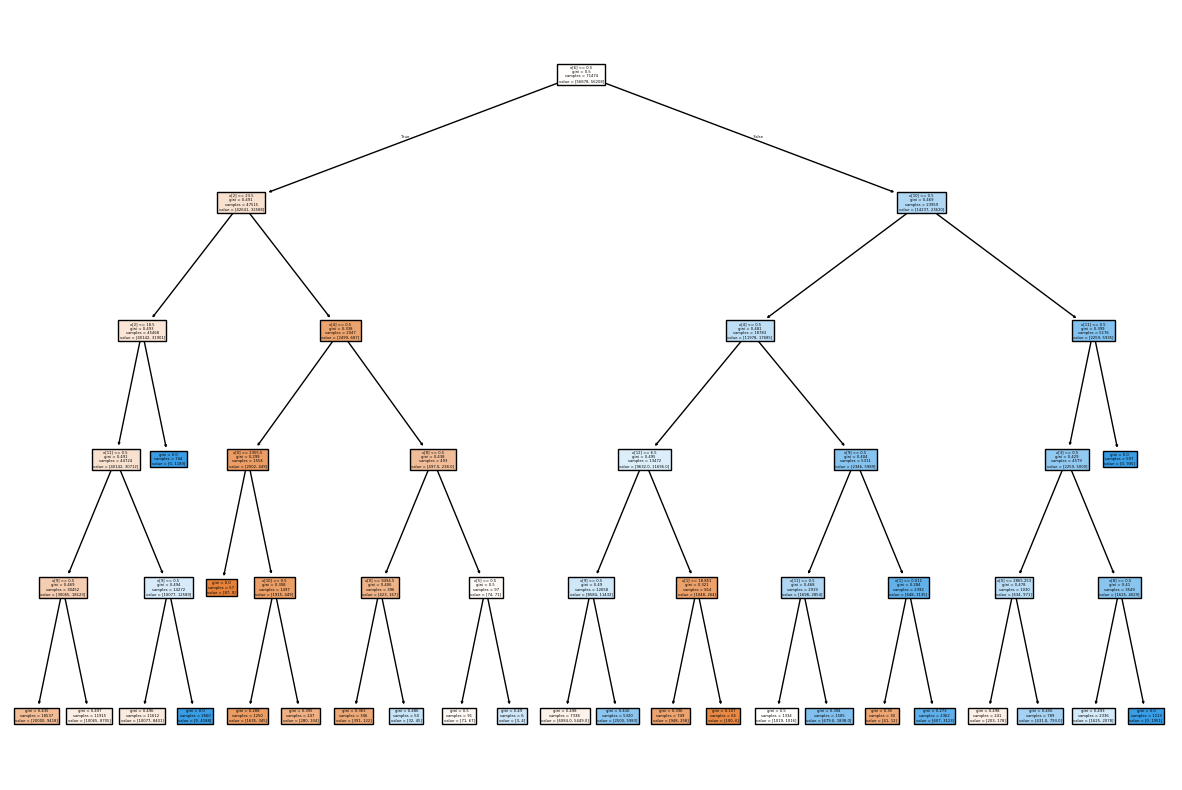

In [1264]:
plt.figure(figsize=(15,10))
tree.plot_tree(rf_model.estimators_[4],filled=True)

In [1262]:
importance = pd.DataFrame(rf_model.feature_importances_, index=X.columns)
print(importance)

                                              0
Valor médio do carro por mês           0.004106
Desconto aplicado no contrato          0.044908
Tempo de aluguel                       0.033345
Tipo do cliente_b2c                    0.008876
Histórico de contratos anteriores_sim  0.068792
Qualidade do carro_ruim                0.002436
Tipo de transmissão_manual             0.137255
Marca do carro_ford                    0.066217
Marca do carro_honda                   0.084692
Marca do carro_nissan                  0.194161
Marca do carro_toyota                  0.079924
Marca do carro_volkswagen              0.187055
Idade do carro                         0.088235


In [1265]:
#comparar o resultado do teste do db sem alteracao com o resultado do db com alteracao, com a mesma qtd de ambas categorias, por conta do SMOTE
y_pred = rf_model.predict(X_test) #testando o modelo com dados nunca vistos anteriormente, que é o X_test

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.80      0.85     37696
           1       0.10      0.19      0.13      4130

    accuracy                           0.74     41826
   macro avg       0.50      0.50      0.49     41826
weighted avg       0.82      0.74      0.78     41826



In [1164]:
# Optionally, if you want to get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[25594  2678]
 [ 2796   302]]


In [1168]:
importance = pd.DataFrame(rf_model.feature_importances_, index=X.columns)
print(importance)

                                              0
Valor médio do carro por mês           0.004573
Desconto aplicado no contrato          0.273853
Tempo de aluguel                       0.216048
Tipo do cliente_b2c                    0.086024
Histórico de contratos anteriores_sim  0.356470
Qualidade do carro_ruim                0.063032
